In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import shutil

src_folder = '/content/drive/My Drive/[Subtitlist] naruto-season-1-english-2206507'
dst_folder = '/content/subtitles'

import os

if os.path.exists(dst_folder):
    print("Destination folder already exists.")
else:
    shutil.copytree(src_folder, dst_folder)



In [3]:
!pip install transformers

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from transformers import pipeline

from nltk import sent_tokenize
import nltk
from time import time
import matplotlib.pyplot as plt
import torch

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
substitles_paths = sorted(glob("/content/subtitles/*.ass"))


In [7]:
scripts = []
episode_num = []
for path in substitles_paths:

    with open(path,'r') as file:
        lines = file.readlines()
        lines = lines[27:]

        rows = [",".join(line.split(',')[9:]) for line in lines]

    rows = [line.replace("\\N",' ') for line in rows]
    script = " ".join(rows)

    episode = int(path.split('-')[1].split('.')[0].strip())

    scripts.append(script)
    episode_num.append(episode)

In [8]:
df = pd.DataFrame.from_dict({'episode':episode_num,'script':scripts})

In [9]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


In [10]:
device = 0 if torch.cuda.is_available() else 'cpu'


In [11]:
from transformers import pipeline
theme_classifier = pipeline("zero-shot-classification",
                      model= 'facebook/bart-large-mnli',
                      device=device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
theme_classifier("I have a problem with my iphone that needs to be resolved asap!",
    candidate_labels=["urgent", "not urgent", "phone", "tablet", "computer"],
    multi_label=False
)

{'sequence': 'I have a problem with my iphone that needs to be resolved asap!',
 'labels': ['urgent', 'phone', 'computer', 'not urgent', 'tablet'],
 'scores': [0.5227577686309814,
  0.45814040303230286,
  0.014264780096709728,
  0.0026850062422454357,
  0.0021520727314054966]}

In [13]:
def get_themes(script):
    script_sentences = sent_tokenize(script)

    # Batch sentences
    script_batches = []
    sentence_batch_size=20
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)

    # Run model
    candidate_labels = ['friendship','hope', 'sacrifice', 'battle','self development','betrayal','love','dialogue']
    emotion_output = theme_classifier(script_batches,
                       candidate_labels,multi_label=True)

    # Wrangle Output
    emotions={}
    for output in  emotion_output:
        for label, score in zip(output['labels'],output['scores']):
            if label not in emotions:
                emotions[label]=[]
            emotions[label].append(score)

    emotions =  {key:np.mean(np.array(value)) for key,value in emotions.items()}

    return emotions

In [14]:
output_emotions = df['script'].apply(get_themes)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [15]:
emotion_df = pd.DataFrame(output_emotions.tolist())

In [16]:

emotion_df.head()

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.933065,0.843436,0.730703,0.738851,0.786690,0.356776,0.270746,0.171008
1,0.878906,0.523089,0.614091,0.560678,0.723522,0.360577,0.199374,0.126210
2,0.914470,0.591376,0.700835,0.721964,0.739588,0.379512,0.339813,0.260938
3,0.704726,0.346729,0.641507,0.494499,0.496159,0.230442,0.110953,0.133850
4,0.818597,0.680574,0.750627,0.708856,0.653921,0.301845,0.238132,0.113576


In [17]:
df[emotion_df.columns] = emotion_df

In [18]:
theme_output = df.drop(['episode','script','dialogue'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,betrayal,123.675035
1,battle,154.715120
2,sacrifice,158.352471
3,self development,145.778282
4,hope,89.345913
5,friendship,75.649576
6,love,46.516704


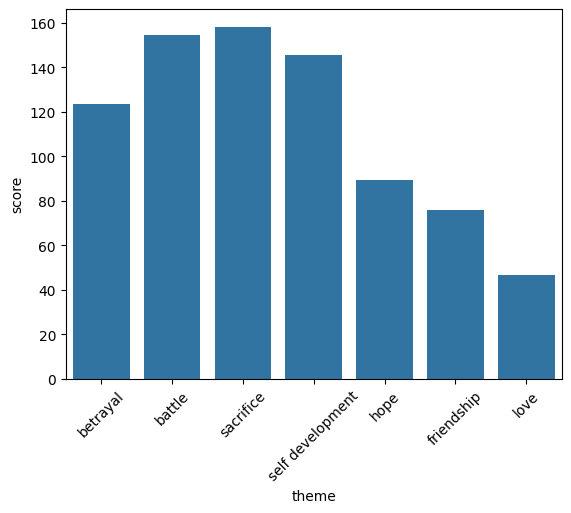

In [19]:
import seaborn as sns
sns.barplot(data=theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()